In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use(["science", "ieee"])
import datetime as dt
import sys
sys.path.append("py/")
from fetch import *

In [2]:
digi = FetchDigisonde("dataset/Mabie/lusk.sav")
of150x = FetchOccult([dt.datetime(2017,8,21,16), 42], 150)
of240x = FetchOccult([dt.datetime(2017,8,21,16), 42], 240)
digi.data.head()

,timevals,foe,fof1,fxf1,fof2,fxf2,ofof1,ofxf1,ofof2,ofxf2,time
0,0.0,NaN,4.214120,4.937748,4.937748,5.667667,NaN,5.746366,5.619031,6.285315,2017-08-21 16:00:00
1,2.0,NaN,4.199632,4.963337,4.954792,5.677445,NaN,5.836213,5.628725,6.450001,2017-08-21 16:02:00
2,4.0,NaN,4.221383,4.954792,4.946263,5.667667,NaN,5.806109,5.590050,6.405667,2017-08-21 16:04:00
3,6.0,NaN,4.221383,4.895394,4.937748,5.677445,4.963337,5.836213,5.475617,6.350677,2017-08-21 16:06:00
4,8.0,NaN,4.228658,4.937748,4.963337,5.667667,5.226662,5.756280,5.494525,6.209912,2017-08-21 16:08:00


Text(0.95, 0.9, '(a)')

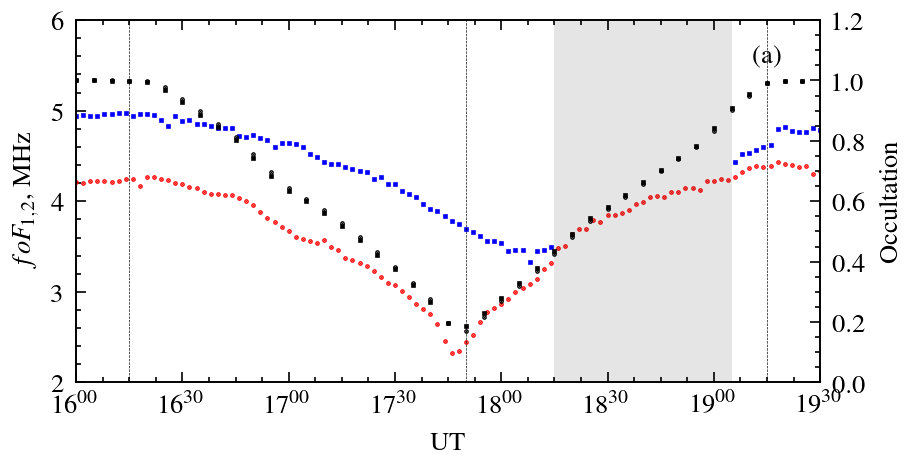

In [3]:
fig = plt.figure(dpi=240, figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_ylabel(r"$foF_{1,2}$, MHz")
ax.set_xlabel("UT")
ax.set_ylim(2,6)
ax.xaxis.set_major_formatter(mdates.DateFormatter(r"%H^{%M}"))
ax.set_xlim([dt.datetime(2017,8,21,16), dt.datetime(2017,8,21,19, 30)])
ax.plot(digi.data.time, digi.data.fof1, "ro", ms=0.4, ls="None")
ax.plot(digi.data.time, digi.data.fof2, "bs", ms=0.4, ls="None")
ax = ax.twinx()
ax.set_ylim(0, 1.2)
ax.set_ylabel("Occultation")
ax.plot(of150x.data.time, of150x.data.of, "ko", ms=0.4, ls="None")
ax.plot(of240x.data.time, of240x.data.of, "ks", ms=0.4, ls="None")
ax.axvline(dt.datetime(2017,8,21,16,15), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,17,50), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,19,15), ls="--", lw=0.2, color="k")
ax.axvspan(dt.datetime(2017,8,21,18,15), dt.datetime(2017,8,21,19,5), alpha=0.1)
ax.text(0.95, 0.9, "(a)", ha="right", va="center", transform=ax.transAxes)

In [4]:
headersm = [
    'GDALT', 
    'GDLAT',
    'GLON', 
    'TEC', 
    'NEMAX',
    'HMAX', 
    'POPL', 
    'DPOPL',
    'TI',
    'DTI', 
    'PM',
    'DPM',
    'VI3', 
    'DVI3', 
    'TR',
    'DTR',
    'CCTITR',
    'DCCTITR',
    'NEL',
    'DNEL',
    'NE',
    'DNE'
]
headersj = [
    "NE",
    "TI",
    "TR",
    "VO",
    "PH+",
    "PM",
    "CO",
    "GDALT",
    "RANGE",
    "AZ1",
    "AZ2",
    "EL1",
    "EL2",
    "GDLAT",
    "GLON",
]

of150 = FetchOccult([dt.datetime(2017,8,21,15,15), 72], 150, "mil")
of240 = FetchOccult([dt.datetime(2017,8,21,15,15), 72], 240, "mil")
isr = FetchISR("dataset/ISR/mlh170821m.004.txt", headers=headersm)
ISR = isr.data.copy()
def get_gridded_parameters(q, xparam="DATE", yparam="GDALT", zparam="NE", r=0, rounding=False):
    """
    Method converts scans to "beam" and "slist" or gate
    """
    plotParamDF = q[ [xparam, yparam, zparam] ]
    if rounding:
        plotParamDF.loc[:, xparam] = np.round(plotParamDF[xparam].tolist(), r)
        plotParamDF.loc[:, yparam] = np.round(plotParamDF[yparam].tolist(), r)
    else:
        plotParamDF[xparam] = plotParamDF[xparam].tolist()
        plotParamDF[yparam] = plotParamDF[yparam].tolist()
    plotParamDF = plotParamDF.groupby( [xparam, yparam] ).mean().reset_index()
    plotParamDF = plotParamDF[ [xparam, yparam, zparam] ].pivot( xparam, yparam )
    x = plotParamDF.index.values
    y = plotParamDF.columns.levels[1].values
    X, Y  = np.meshgrid( x, y )
    # Mask the nan values! pcolormesh can't handle them well!
    Z = np.ma.masked_where(
            np.isnan(plotParamDF[zparam].values),
            plotParamDF[zparam].values)
    return X,Y,Z
X, Y, Z = get_gridded_parameters(ISR)
hmax, Tx = [], []
ISRO = ISR[(ISR.DATE>=dt.datetime(2017,8,21,15)) & (ISR.DATE<=dt.datetime(2017,8,21,21))]
for t in ISRO.DATE.unique():
    Tx.append(t)
    u = ISRO[ISRO.DATE==t]
    hmax.append(u.GDALT.tolist()[np.argmax(u.NE)])

['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'GDALT', 'GDLAT', 'GLON', 'TEC', 'NEMAX', 'HMAX', 'POPL', 'DPOPL', 'TI', 'DTI', 'PM', 'DPM', 'VI3', 'DVI3', 'TR', 'DTR', 'CCTITR', 'DCCTITR', 'NEL', 'DNEL', 'NE', 'DNE']


/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
params = [
    {
        "name": "e",
        "unit_multiplier": 1.,
        "unit": "cc",
        "mol_to_cc": "T",
        "interpolate": {"scale": "log", "type": "linear"},
    }
]
dw = DiffWACCMX(
        "dataset/29jan2022/ECL_1100_0100_all.nc",
        "dataset/29jan2022/BGC_1100_0100_all.nc",
        params=params,
        stn="lusk",
    )

2022-10-06 23:45:48.334 | INFO     | fetch:__init__:230 - Run extraction for dataset/29jan2022/ECL_1100_0100_all.nc
2022-10-06 23:45:48.335 | INFO     | fetch:load_file:265 - Load dataset/29jan2022/ECL_1100_0100_all.nc
2022-10-06 23:45:48.512 | INFO     | fetch:extract_dimension:273 - Run extraction dimension: dataset/29jan2022/ECL_1100_0100_all.nc
2022-10-06 23:45:57.143 | INFO     | fetch:run_extractions:292 - Load dataset/29jan2022/ECL_1100_0100_all.nc, e
2022-10-06 23:46:11.499 | INFO     | fetch:transform_density:251 - Transform density scale/unit dataset/29jan2022/ECL_1100_0100_all.nc
2022-10-06 23:46:12.862 | INFO     | fetch:__init__:230 - Run extraction for dataset/29jan2022/BGC_1100_0100_all.nc
2022-10-06 23:46:12.863 | INFO     | fetch:load_file:265 - Load dataset/29jan2022/BGC_1100_0100_all.nc
2022-10-06 23:46:13.030 | INFO     | fetch:extract_dimension:273 - Run extraction dimension: dataset/29jan2022/BGC_1100_0100_all.nc
2022-10-06 23:46:20.943 | INFO     | fetch:run_extr

In [25]:
odf = []
with open("dataset/ISR/MLH_ISR_Ne_gridded_21-Aug-2017.txt", "r") as f:
    lines = f.readlines()
    for ix, line in enumerate(lines[1:]):
        line = list(filter(None, line.replace("\n", "").split(" ")))
        odf.append({"UT": float(line[0]), "alt": float(line[1]), "el": float(line[2])})
odf = pd.DataFrame.from_records(odf)
odf.head(1000)

,UT,alt,el
0,10.0,90.0,NaN
1,10.0,95.0,NaN
2,10.0,100.0,NaN
3,10.0,105.0,NaN
4,10.0,110.0,NaN
...,...,...,...
995,10.9,430.0,4.674000e+10
996,10.9,435.0,4.689000e+10
997,10.9,440.0,4.662000e+10
998,10.9,445.0,4.569000e+10


In [13]:
k = pconst["q_e"]**2/(pconst["m_e"]*pconst["eps0"])
e_eclipse = dw.eclipse.dataset[0]["interpol_value"]["value"]
ttime = dw.eclipse.dataset[0]["interpol_value"]["time"]
f_240, f_150 = (
    np.sqrt(e_eclipse[:, np.argmin(np.abs(dw.eclipse.intp_height-240))]*1e6*k)/(2*np.pi), 
    np.sqrt(e_eclipse[:, np.argmin(np.abs(dw.eclipse.intp_height-150))]*1e6*k)/(2*np.pi)
)
e_eclipse.shape

(143, 550)

In [14]:
f_dif = (f_240-f_150)
f_dif_max = (abs(np.min(f_dif))*(2*np.pi))**2/k/1e6
f_dif_dur = 5*np.sum(f_dif <= 0, axis=0)

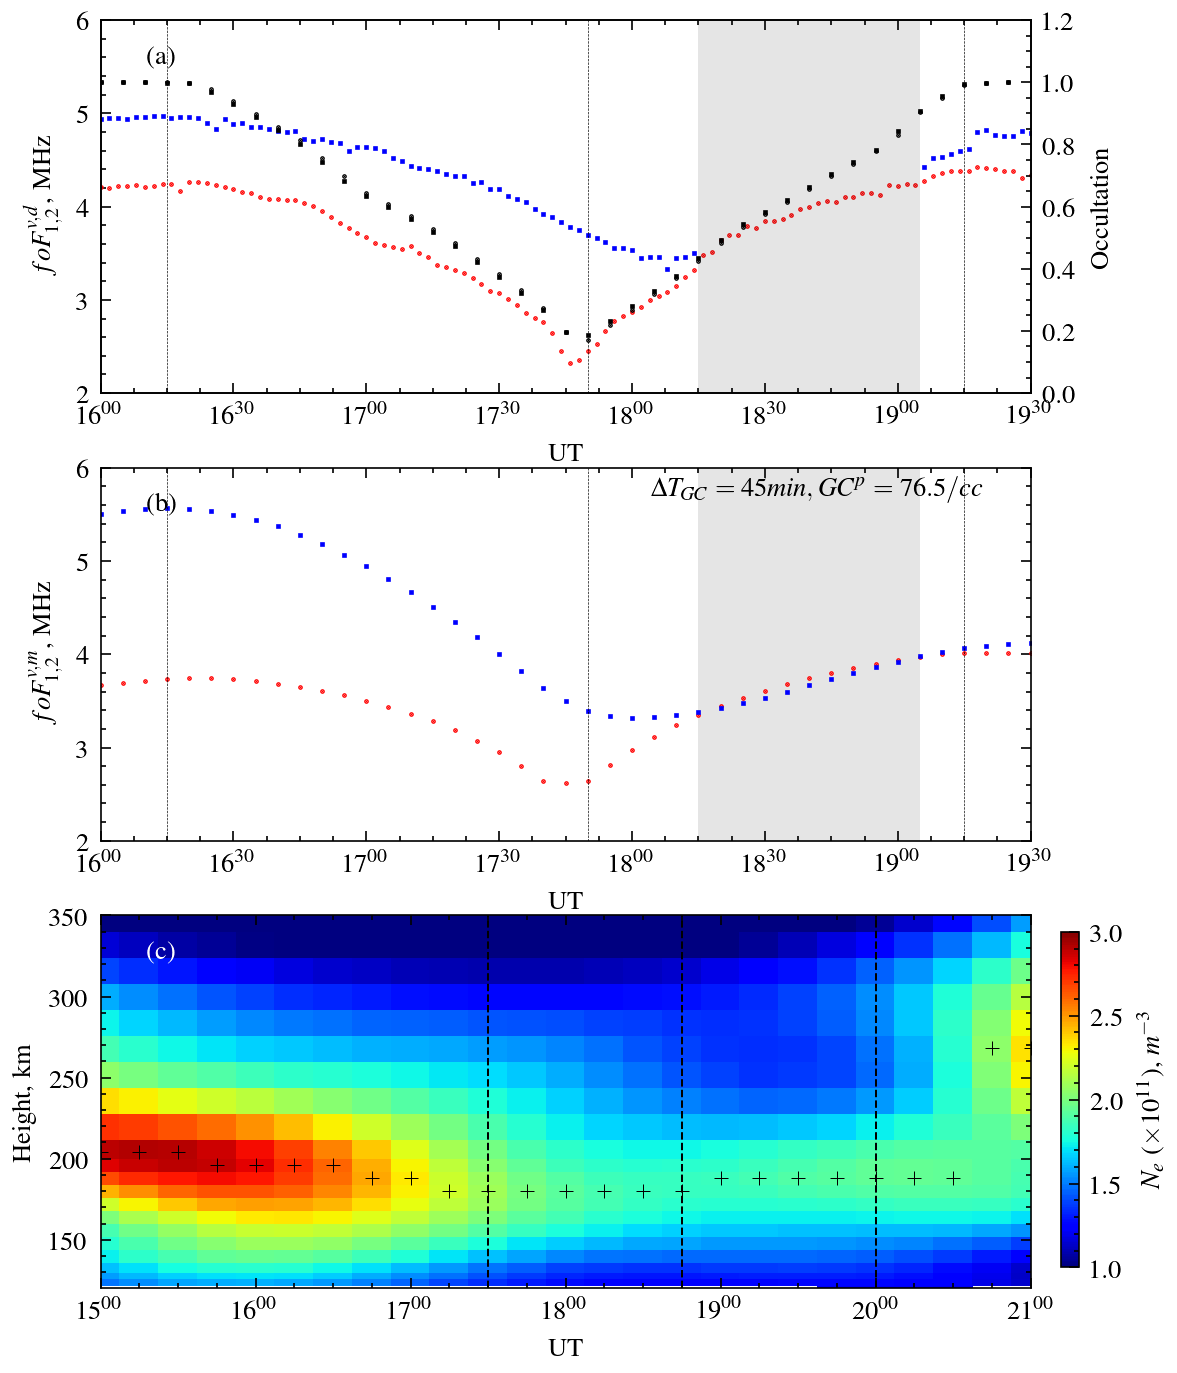

In [15]:
fig = plt.figure(dpi=240, figsize=(5,7))
ax = fig.add_subplot(311)
ax.set_ylabel(r"$foF_{1,2}^{v,d}$, MHz")
ax.set_xlabel("UT")
ax.set_ylim(2,6)
ax.xaxis.set_major_formatter(mdates.DateFormatter(r"%H^{%M}"))
ax.set_xlim([dt.datetime(2017,8,21,16), dt.datetime(2017,8,21,19, 30)])
ax.plot(digi.data.time, digi.data.fof1, "ro", ms=0.4, ls="None")
ax.plot(digi.data.time, digi.data.fof2, "bs", ms=0.4, ls="None")
ax = ax.twinx()
ax.set_ylim(0, 1.2)
ax.set_ylabel("Occultation")
ax.plot(of150x.data.time, of150x.data.of, "ko", ms=0.4, ls="None")
ax.plot(of240x.data.time, of240x.data.of, "ks", ms=0.4, ls="None")
ax.axvline(dt.datetime(2017,8,21,16,15), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,17,50), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,19,15), ls="--", lw=0.2, color="k")
ax.axvspan(dt.datetime(2017,8,21,18,15), dt.datetime(2017,8,21,19,5), alpha=0.1)
ax.text(0.05, 0.9, "(a)", ha="left", va="center", transform=ax.transAxes)

bounds = list(np.arange(1, 3.01, .01))
cmap = plt.cm.jet
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

from scipy import constants as C
k = C.elementary_charge**2/(C.m_e*C.epsilon_0)

ax = fig.add_subplot(313)
ax.set_ylabel("Height, km")
ax.set_xlabel("UT")
ax.xaxis.set_major_formatter(mdates.DateFormatter(r"%H^{%M}"))
ax.set_xlim([dt.datetime(2017,8,21,15), dt.datetime(2017,8,21,21)])
im = ax.pcolor(X, Y, Z.T/1e11, cmap=cmap, norm=norm)
ax.set_ylim(120, 350)
ax.plot(Tx, hmax, color="k", marker="+", ms=4, markeredgewidth=0.3, ls="None")
ax.text(0.05, 0.9, "(c)", ha="left", va="center", transform=ax.transAxes, fontdict={"color":"w"})
ax.axvline(dt.datetime(2017,8,21,17,30), ls="--", lw=0.6, color="k")
ax.axvline(dt.datetime(2017,8,21,18,45), ls="--", lw=0.6, color="k")
ax.axvline(dt.datetime(2017,8,21,20), ls="--", lw=0.6, color="k")

# _, _, Zp = get_gridded_parameters(ISR, xparam="DATE", yparam="GDALT", zparam="PM")
# ax = fig.add_subplot(413)
# ax.set_ylabel("Height, km")
# ax.set_xlabel("UT")
# ax.xaxis.set_major_formatter(mdates.DateFormatter(r"%H^{%M}"))
# ax.set_xlim([dt.datetime(2017,8,21,15), dt.datetime(2017,8,21,21)])
# ax.pcolor(X, Y, Z.T*Zp.T/1e11, cmap=cmap, norm=norm)
# ax.set_ylim(120, 350)
# ax.text(0.95, 0.9, "(c)", ha="right", va="center", transform=ax.transAxes, fontdict={"color":"w"})
# ax.axvline(dt.datetime(2017,8,21,17,30), ls="--", lw=0.6, color="k")
# ax.axvline(dt.datetime(2017,8,21,18,45), ls="--", lw=0.6, color="k")
# ax.axvline(dt.datetime(2017,8,21,20), ls="--", lw=0.6, color="k")

# ax = fig.add_subplot(414)
# ax.set_ylabel("Height, km")
# ax.set_xlabel("UT")
# ax.xaxis.set_major_formatter(mdates.DateFormatter(r"%H^{%M}"))
# ax.set_xlim([dt.datetime(2017,8,21,15), dt.datetime(2017,8,21,21)])
# im = ax.pcolor(X, Y, (Z.T - Z.T*Zp.T)/1e11, cmap=cmap, norm=norm)
# ax.set_ylim(120, 350)
# ax.text(0.95, 0.9, "(d)", ha="right", va="center", transform=ax.transAxes, fontdict={"color":"w"})
# ax.axvline(dt.datetime(2017,8,21,17,45), ls="--", lw=0.6, color="k")
# ax.axvline(dt.datetime(2017,8,21,18,45), ls="--", lw=0.6, color="k")
# ax.axvline(dt.datetime(2017,8,21,19,45), ls="--", lw=0.6, color="k")

pos = ax.get_position()
cpos = [pos.x1 + 0.025, pos.y0 + 0.0125,
        0.015, pos.height * 0.9]                # this list defines (left, bottom, width, height
cax = fig.add_axes(cpos)
bounds = list(np.arange(1, 3.1, .5))
cb2 = mpl.colorbar.ColorbarBase(cax,
                                spacing="uniform",
                                orientation="vertical", 
                                cmap=cmap,
                                norm=norm,
                                ticks=bounds)
cb2.set_label(r"$N_e$ ($\times 10^{11}$), $m^{-3}$")


ax = fig.add_subplot(312)
ax.set_ylabel(r"$foF_{1,2}^{v,m}$, MHz")
ax.set_xlabel("UT")
ax.set_ylim(2,6)
ax.xaxis.set_major_formatter(mdates.DateFormatter(r"%H^{%M}"))
ax.plot(ttime, f_150/1e6, "ro", ms=0.4, ls="None")
ax.plot(ttime, f_240/1e6, "bs", ms=0.4, ls="None")
ax.axvline(dt.datetime(2017,8,21,16,15), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,17,50), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,19,15), ls="--", lw=0.2, color="k")
ax.set_xlim([dt.datetime(2017,8,21,16), dt.datetime(2017,8,21,19, 30)])
ax.text(0.05, 0.9, "(b)", ha="left", va="center", transform=ax.transAxes)
ax.text(0.95, 0.98, r"$\Delta T_{GC}=%d min, GC^p=%.1f /cc$"%(f_dif_dur,f_dif_max), 
        transform=ax.transAxes, ha="right", va="top", fontdict={"size":8})
_ = ax.axvspan(dt.datetime(2017,8,21,18,15), dt.datetime(2017,8,21,19,5), alpha=0.1)



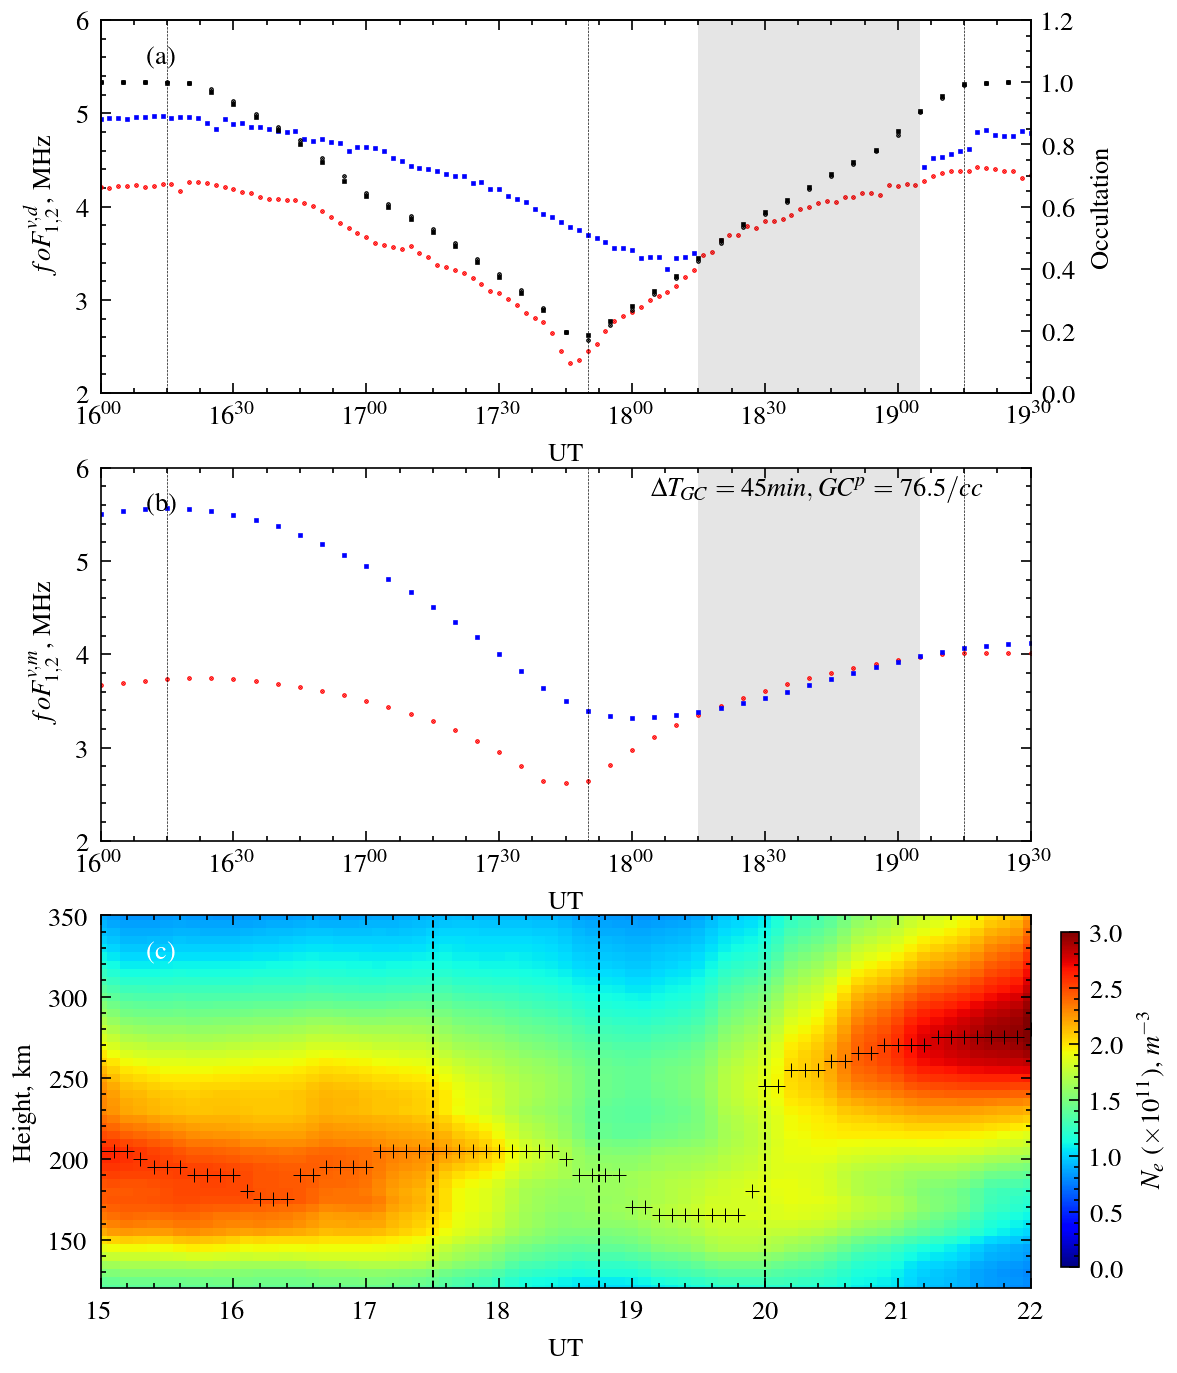

In [50]:
fig = plt.figure(dpi=240, figsize=(5,7))
ax = fig.add_subplot(311)
ax.set_ylabel(r"$foF_{1,2}^{v,d}$, MHz")
ax.set_xlabel("UT")
ax.set_ylim(2,6)
ax.xaxis.set_major_formatter(mdates.DateFormatter(r"%H^{%M}"))
ax.set_xlim([dt.datetime(2017,8,21,16), dt.datetime(2017,8,21,19, 30)])
ax.plot(digi.data.time, digi.data.fof1, "ro", ms=0.4, ls="None")
ax.plot(digi.data.time, digi.data.fof2, "bs", ms=0.4, ls="None")
ax = ax.twinx()
ax.set_ylim(0, 1.2)
ax.set_ylabel("Occultation")
ax.plot(of150x.data.time, of150x.data.of, "ko", ms=0.4, ls="None")
ax.plot(of240x.data.time, of240x.data.of, "ks", ms=0.4, ls="None")
ax.axvline(dt.datetime(2017,8,21,16,15), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,17,50), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,19,15), ls="--", lw=0.2, color="k")
ax.axvspan(dt.datetime(2017,8,21,18,15), dt.datetime(2017,8,21,19,5), alpha=0.1)
ax.text(0.05, 0.9, "(a)", ha="left", va="center", transform=ax.transAxes)

bounds = list(np.arange(0.5, 3.01, .5))
cmap = plt.cm.jet

from scipy import constants as C
k = C.elementary_charge**2/(C.m_e*C.epsilon_0)

Tx, hmax = [], []
for t in odf.UT.unique():
    Tx.append(t)
    u = odf[odf.UT==t]
    hmax.append(u.alt.tolist()[np.argmax(u.el)])

ax = fig.add_subplot(313)
ax.set_ylabel("Height, km")
ax.set_xlabel("UT")
X, Y, Z = get_gridded_parameters(odf, "UT", "alt", "el")
im = ax.pcolor(X, Y, Z.T/1e11, cmap=cmap, vmax=3, vmin=0)
ax.set_ylim(120, 350)
ax.set_xlim(15, 22)
ax.plot(Tx, hmax, color="k", marker="+", ms=4, markeredgewidth=0.3, ls="None")
ax.text(0.05, 0.9, "(c)", ha="left", va="center", transform=ax.transAxes, fontdict={"color":"k"})
ax.axvline(17.50, ls="--", lw=0.6, color="k")
ax.axvline(18.75, ls="--", lw=0.6, color="k")
ax.axvline(20.00, ls="--", lw=0.6, color="k")


pos = ax.get_position()
cpos = [pos.x1 + 0.025, pos.y0 + 0.0125,
        0.015, pos.height * 0.9]                # this list defines (left, bottom, width, height
cax = fig.add_axes(cpos)
cb2 = fig.colorbar(im, cax,
                   spacing="uniform",
                   orientation="vertical", 
                   cmap=cmap)
cb2.set_label(r"$N_e$ ($\times 10^{11}$), $m^{-3}$")


ax = fig.add_subplot(312)
ax.set_ylabel(r"$foF_{1,2}^{v,m}$, MHz")
ax.set_xlabel("UT")
ax.set_ylim(2,6)
ax.xaxis.set_major_formatter(mdates.DateFormatter(r"%H^{%M}"))
ax.plot(ttime, f_150/1e6, "ro", ms=0.4, ls="None")
ax.plot(ttime, f_240/1e6, "bs", ms=0.4, ls="None")
ax.axvline(dt.datetime(2017,8,21,16,15), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,17,50), ls="--", lw=0.2, color="k")
ax.axvline(dt.datetime(2017,8,21,19,15), ls="--", lw=0.2, color="k")
ax.set_xlim([dt.datetime(2017,8,21,16), dt.datetime(2017,8,21,19, 30)])
ax.text(0.05, 0.9, "(b)", ha="left", va="center", transform=ax.transAxes)
ax.text(0.95, 0.98, r"$\Delta T_{GC}=%d min, GC^p=%.1f /cc$"%(f_dif_dur,f_dif_max), 
        transform=ax.transAxes, ha="right", va="top", fontdict={"size":8})
_ = ax.axvspan(dt.datetime(2017,8,21,18,15), dt.datetime(2017,8,21,19,5), alpha=0.1)

